In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
import imageio
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

from utils import *

import tensorflow as tf
from keras import backend as K

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPool2D,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

from vgg_19 import VGG19


In [2]:
IMAGE_DIR = 'images'
os.listdir(path = IMAGE_DIR)

['cafe.jpg',
 'dynamite.jpg',
 'painting.jpg',
 'rudolph.jpg',
 'swan.jpg',
 'tnj.jpg']

In [3]:
# set default images
content_path = f'{IMAGE_DIR}/swan.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

In [4]:
image = imageio.imread(content_path)

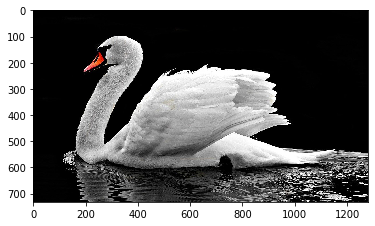

In [5]:
plt.imshow(image)

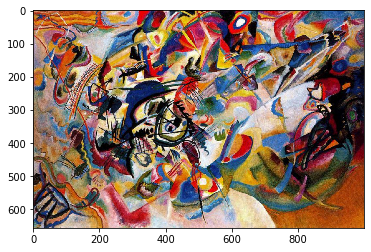

In [6]:
image = imageio.imread(style_path)
plt.imshow(image)

In [7]:
vgg_19 = VGG19(include_top=False)
vgg_19.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [8]:
for i in enumerate(vgg_19.layers):
    print(i)

(0, <keras.engine.input_layer.InputLayer object at 0x0000022515167F08>)
(1, <keras.layers.convolutional.Conv2D object at 0x00000225151A1148>)
(2, <keras.layers.convolutional.Conv2D object at 0x00000225151A1948>)
(3, <keras.layers.pooling.MaxPooling2D object at 0x0000022515145E48>)
(4, <keras.layers.convolutional.Conv2D object at 0x00000225156815C8>)
(5, <keras.layers.convolutional.Conv2D object at 0x000002251567CAC8>)
(6, <keras.layers.pooling.MaxPooling2D object at 0x000002251568EF08>)
(7, <keras.layers.convolutional.Conv2D object at 0x000002251569C1C8>)
(8, <keras.layers.convolutional.Conv2D object at 0x000002251569CC08>)
(9, <keras.layers.convolutional.Conv2D object at 0x000002251568E748>)
(10, <keras.layers.convolutional.Conv2D object at 0x000002251516AE48>)
(11, <keras.layers.pooling.MaxPooling2D object at 0x000002251563E308>)
(12, <keras.layers.convolutional.Conv2D object at 0x0000022515692048>)
(13, <keras.layers.convolutional.Conv2D object at 0x00000225156A6F48>)
(14, <keras.la

> we will use these layers for style loss and content loss
- style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 
- content_layers = ['block5_conv2'] 

>### Model

In [9]:
style_content_index = [1 , 4 , 7 ,12 ,17 ,18] # indexes of the layers i want 
NUM_STYLE_LAYERS = 5
NUM_CONTENT_LAYERS = 1
outputs = [vgg_19.get_layer(index = index).output for index in style_content_index]

In [10]:
outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv1_0')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'conv2_0')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'conv3_0')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'conv4_0')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'conv5_0')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'conv5_1')>]

In [11]:
model = tf.keras.Model(inputs = vgg_19.input , outputs = outputs)
model.trainable = False # i want to extract features only

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1_0 (Conv2D)            (None, None, None, 64)    1792      
                                                                 
 conv1_1 (Conv2D)            (None, None, None, 64)    36928     
                                                                 
 maxpool1 (MaxPooling2D)     (None, None, None, 64)    0         
                                                                 
 conv2_0 (Conv2D)            (None, None, None, 128)   73856     
                                                                 
 conv2_1 (Conv2D)            (None, None, None, 128)   147584    
                                                                 
 maxpool2 (MaxPooling2D)     (None, None, None, 128)   0     

>### losses

In [13]:
def gram_matrix(input_tensor):
    """ Calculates the gram matrix and divides by the number of locations
    Args:
    input_tensor: tensor of shape (batch, height, width, channels)

    Returns:
    scaled_gram: gram matrix divided by the number of locations
    """

    # calculate the gram matrix of the input tensor
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

    # get the height and width of the input tensor
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 

    # get the number of locations (height times width), and cast it as a tf.float32
    num_locations = tf.cast(height * width, tf.float32)

    # scale the gram matrix by dividing by the number of locations
    scaled_gram = gram / num_locations

    return scaled_gram

In [14]:
def get_style_loss(features, targets):
    """Expects two images of dimension h, w, c

    Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

    Returns:
    style loss (scalar)
    """
    # get the average of the squared errors
    style_loss = tf.reduce_mean(tf.square(features - targets))

    return style_loss

In [15]:
def get_content_loss(features, targets):
    """Expects two images of dimension h, w, c

    Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

    Returns:
    content loss (scalar)
    """
    # get the sum of the squared error multiplied by a scaling factor
    content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

    return content_loss

>### Extract features 

In [16]:
def get_style_image_features(image):  
    """ Get the style image features

    Args:
    image: an input image

    Returns:
    gram_style_features: the style features as gram matrices
    """
    # preprocess the image using the given preprocessing function
    preprocessed_style_image = preprocess_image(image) 

    # get the outputs from the custom vgg model that you created using vgg_model()
    outputs = model(preprocessed_style_image) 

    # Get just the style feature layers (exclude the content layer)
    style_outputs = outputs[:NUM_STYLE_LAYERS] 

    # for each style layer, calculate the gram matrix for that layer and store these results in a list
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 
    
    # we should get gram becuase the loss of the cost is the difference between the two gram matrix of style and the gen
    # unlike the content which the cost will be between the activation
    return gram_style_features

In [17]:
def get_content_image_features(image):
    """ Get the content image features

    Args:
    image: an input image

    Returns:
    content_outputs: the content features of the image
    """
    # preprocess the image
    preprocessed_content_image = preprocess_image(image)

    # get the outputs from the vgg model
    outputs = model(preprocessed_content_image) 

    # get the content layers of the outputs
    content_outputs = outputs[NUM_STYLE_LAYERS:]

    # return the content layer outputs of the content image
    return content_outputs

In [18]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
    """ Combine the style and content loss

    Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

    Returns:
    total_loss: the combined style and content loss

    """

    # sum of the style losses
    style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

    # Sum up the content losses
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

    # scale the style loss by multiplying by the style weight and dividing by the number of style layers
    style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 

    # scale the content loss by multiplying by the content weight and dividing by the number of content layers
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 

    # sum up the style and content losses
    total_loss = style_loss + content_loss 

    return total_loss

>### Calculate Gradients

In [19]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
    """ Calculate the gradients of the loss with respect to the generated image
    Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss

    Returns:
    gradients: gradients of the loss with respect to the input image
    """
    with tf.GradientTape() as tape:

        # get the style image features
        style_features = get_style_image_features(image) # of generated image

        # get the content image features
        content_features = get_content_image_features(image) 

        # get the style and content loss
        loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                      content_features, style_weight, content_weight) 

    # calculate gradients of loss with respect to the image
    gradients = tape.gradient(loss, image) 

    return gradients

In [20]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
    """
    Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    """

    # calculate gradients using the function that you just defined.
    gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

    # apply the gradients to the given image
    optimizer.apply_gradients([(gradients, image)]) 

    # clip the image using the utility clip_image_values() function
    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [21]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
    """ Performs neural style transfer.
    Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch

    Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
    """

    images = []
    step = 0

    # get the style image features 
    style_targets = get_style_image_features(style_image)

    # get the content image features
    content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 

    # collect the image updates starting from the content image
    images.append(content_image)

  # incrementally update the content image with the style features
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
    
      # Update the image with the style using the function that you defined
            update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
            print(".", end='')

            if (m + 1) % 10 == 0:
                images.append(generated_image)
    
    # display the current stylized image
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        # append to the image collection for visualization later
        images.append(generated_image)
        print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, images

In [22]:
content_image, style_image = load_images(content_path, style_path) # load images with and add additional dimension 

In [ ]:
# define style and content weight
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)